In [31]:
import sympy
sympy.init_printing()
u_max, u_star, rho_max, rho_star, A, B = sympy.symbols('u_max u_star rho_max rho_star A B')

In [32]:
eq1 = sympy.Eq(0, u_max*rho_max*(1-A*rho_max-B*rho_max**2))
eq2 = sympy.Eq(0, u_max*(1-2*A*rho_star-3*B*rho_star**2))
eq3 = sympy.Eq(u_star, u_max*(1 - A*rho_star - B*rho_star**2))

In [33]:
eq1

In [34]:
eq2

In [35]:
eq3

In [36]:
eq2 - 3*eq3

In [37]:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4

In [38]:
eq4.simplify()

In [39]:
eq4.expand()

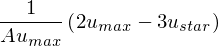

In [40]:
rho_sol = sympy.solve(eq4, rho_star)[0]
rho_sol

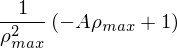

In [41]:
B_sol = sympy.solve(eq1,B)[0]
B_sol

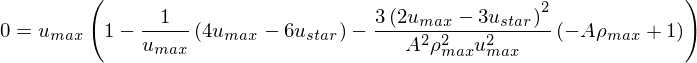

In [42]:
quadA = eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA

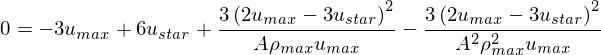

In [43]:
quadA.simplify()

In [44]:
A_sol = sympy.solve(quadA, A)

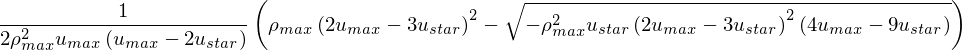

In [45]:
A_sol[0]

In [46]:
aval = A_sol[0].evalf(subs={u_star: 0.7, u_max:1.0, rho_max:10.0})
aval

In [47]:
A_sol[1].evalf(subs={u_star: 0.7, u_max:1.0, rho_max:10.0})

In [48]:
bval = B_sol.evalf(subs={rho_max:10.0, A:aval})
bval

In [49]:
sympy.init_printing(use_latex=False)

In [50]:
rho_max = 10.
u_max = 1.

def computeF(u_max, rho, aval, bval):
    return u_max*rho*(1 - aval*rho - bval*rho**2)

In [51]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [52]:
def rho_green_light(nx, rho_light):
    """Computes 'green light' IC with shock and linear distribution
    
    Parameters:
    nx - number of grid points
    rho_light - density of cars at light
    
    Returns:
    rho_initial - array with initial values of density    
    """
    
    rho_initial = numpy.arange(nx)*2./nx*rho_light # before stoplight
    rho_initial[(nx-1)/2:] = 0
    
    return rho_initial

In [53]:
#ICs, parameters
nx = 81
nt = 30
dx = 4.0/(nx-1)

x = numpy.linspace(0,4, nx)

rho_light=5.5

/home/randy/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


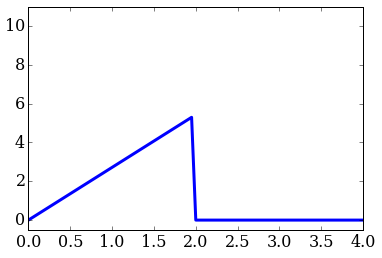

In [54]:
rho_initial = rho_green_light(nx, rho_light)

pyplot.plot(x, rho_initial, lw=3)
pyplot.ylim(-0.5, 11.);

In [55]:
def ftbs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes solution to traffic problem forward in time, backward in space
    
    Parameters: 
        rho - density at current time step
        nt - number of time steps
        dt - time step size
        dx - mesh spacing
        rho_max - max car density
        u_max - speed limit
        
    Returns:
        rho_n - density after nt time steps at each point x
    """
    
    rho_n = numpy.zeros((nt, len(rho)))
    rho_n[0,:] = rho.copy()
    
    for t in range(1, nt):
        F = computeF(u_max, rho, aval, bval)
        rho_n[t,1:] = rho[1:] - dt/dx*(F[1:] - F[:-1])
        rho_n[t,0] = rho[0]
        rho_n[t, -1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n    

In [56]:
sigma = 1.
dt = sigma*dx/u_max

rho_n = ftbs(rho_initial, nt, dt, dx, rho_max, u_max)

In [57]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation


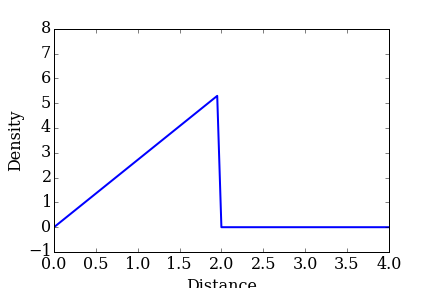
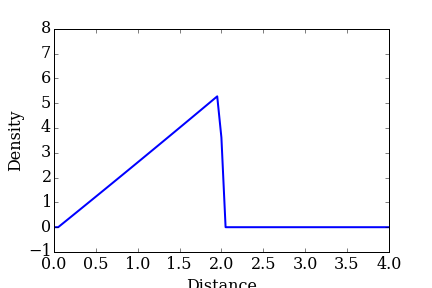
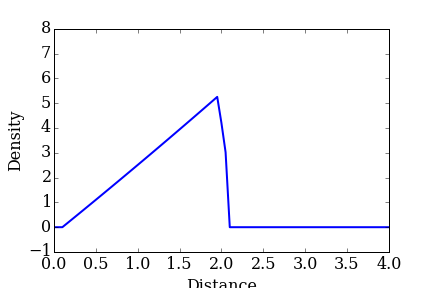
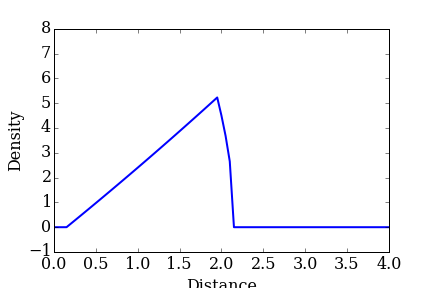
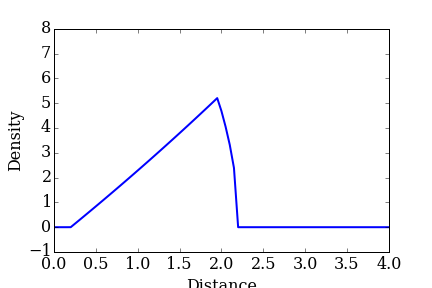
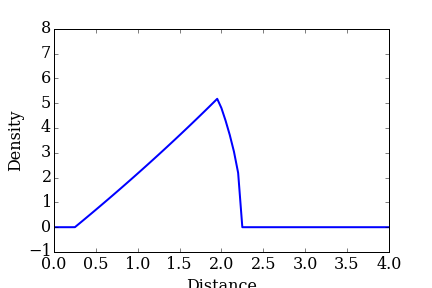
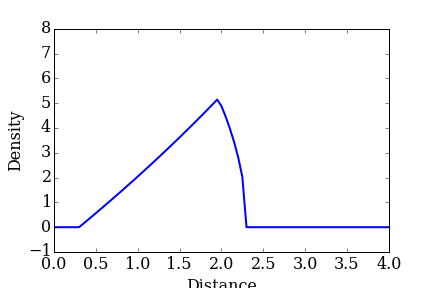
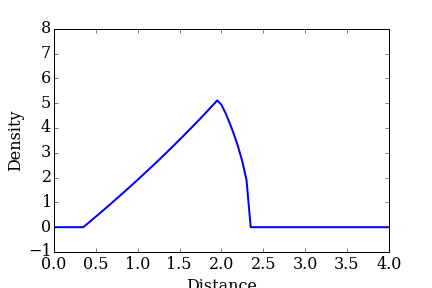
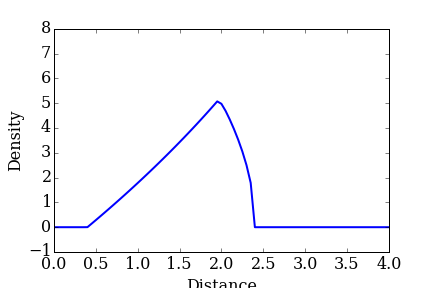
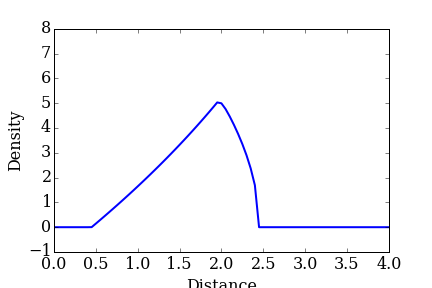
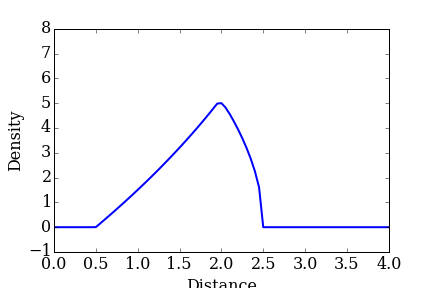
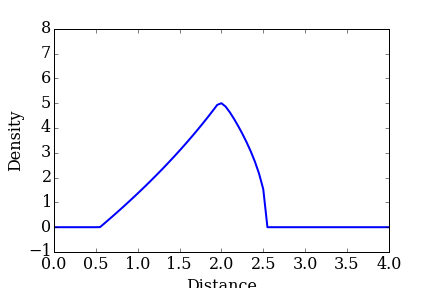
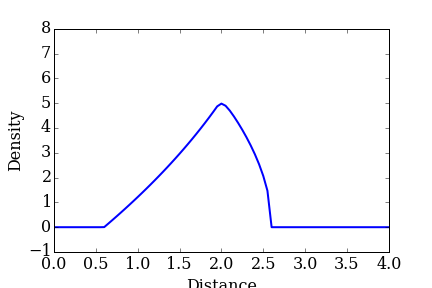
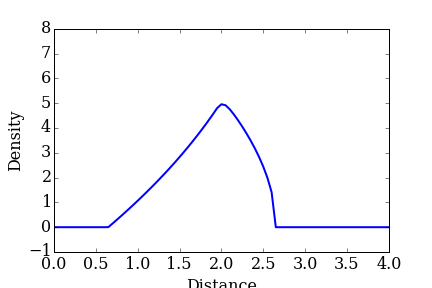
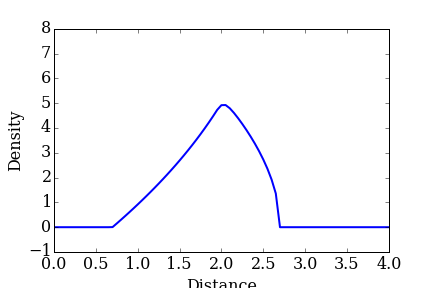
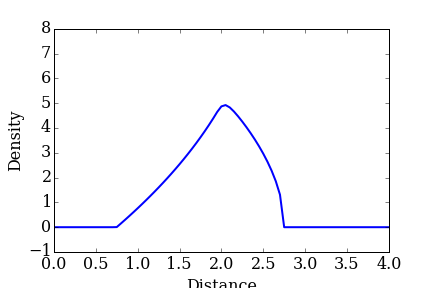
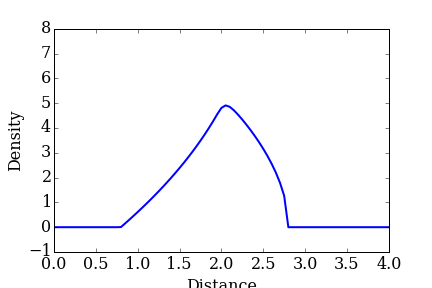
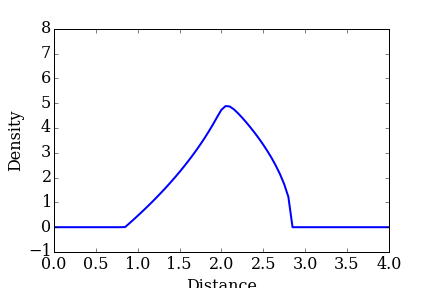
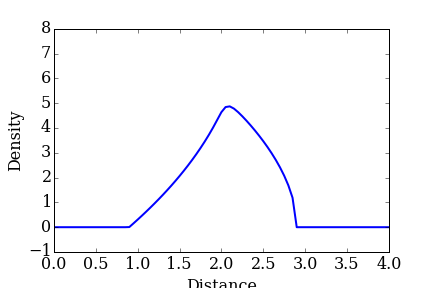
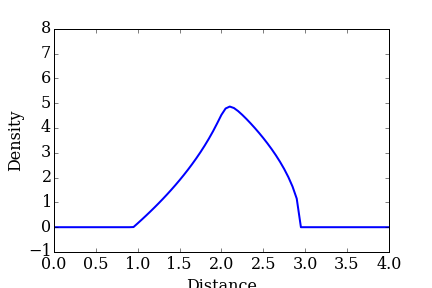
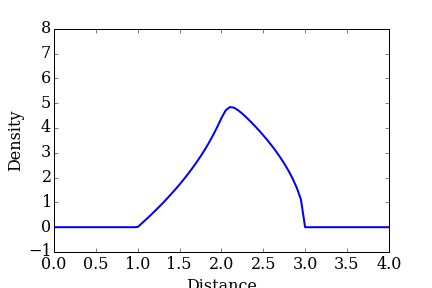
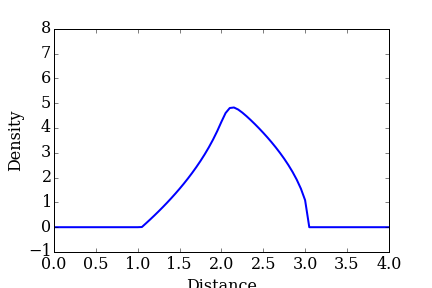
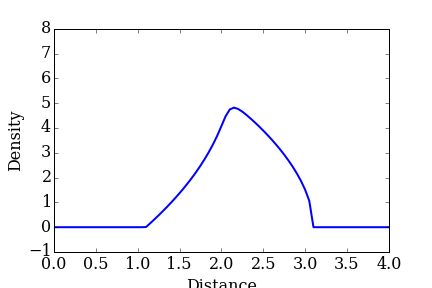
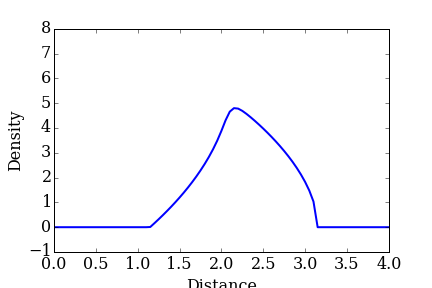
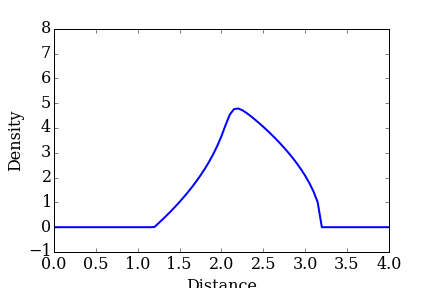
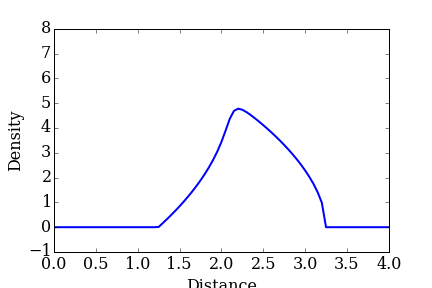
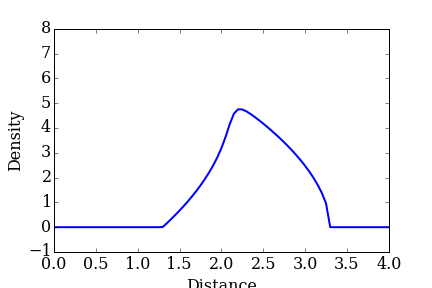
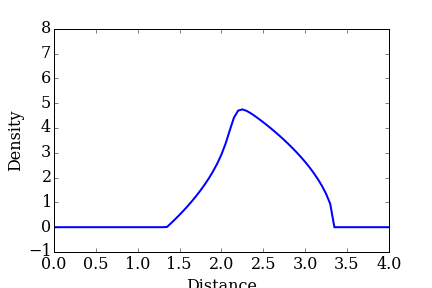
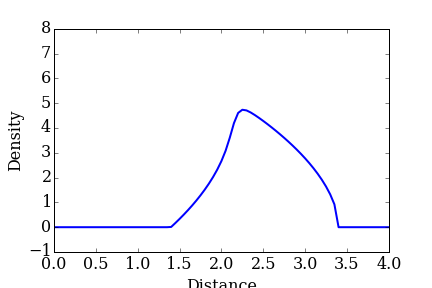
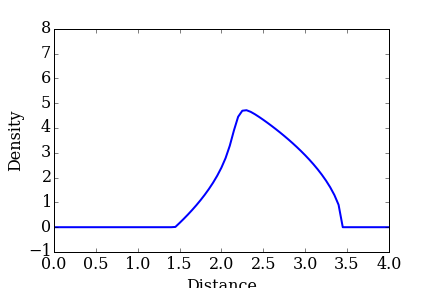

In [58]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(-1,8), xlabel=('Distance'), ylabel=('Density'))
line, = ax.plot([], [], lw=2);

def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

In [79]:
def maccormack(rho, nt, dt, dx, u_max, rho_max):
    """Computes solution with MacCormack scheme
    
    Parameters:
        rho - density at current time step
        nt - number of time steps
        dt - time discretiztion
        dx - space discretization
        rho_max - max density
        u_max - max speed
        
    Returns:
        rho_n - density after nt time steps at each point x
    """
    
    rho_n = numpy.zeros((nt, len(rho)))
    rho_s = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy()
    rho_s = rho.copy()
    
    for t in range(1, nt):
        #F = computeF(u_max, rho_max, rho)
        F = computeF(u_max, rho, aval, bval)
        rho_s[:-1] = rho[:-1] - dt/dx * (F[1:] - F[:-1])
        Fstar = computeF(u_max, rho_s, aval, bval)
        rho_n[t, 1:] = 0.5*(rho[1:]+rho_s[1:] - dt/dx*(Fstar[1:] - Fstar[:-1]))
        rho_n[t, 0] = rho[0]
        rho_n[t, -1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n

/home/randy/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in square



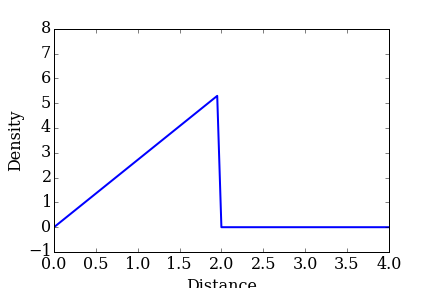
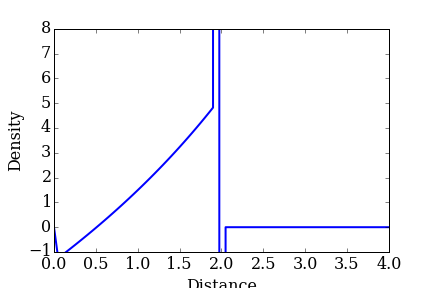
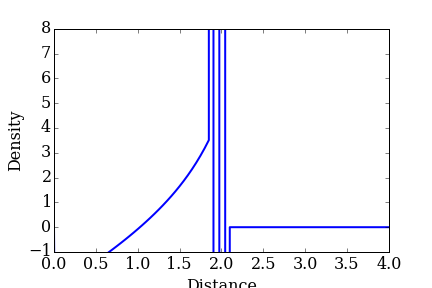
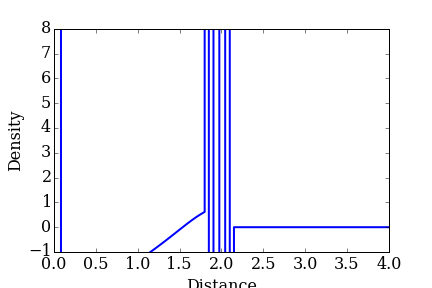
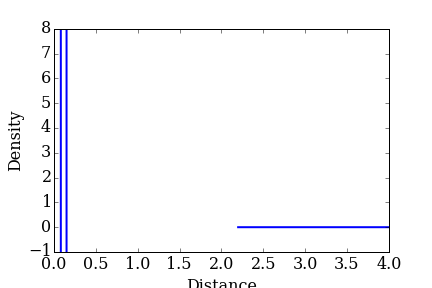
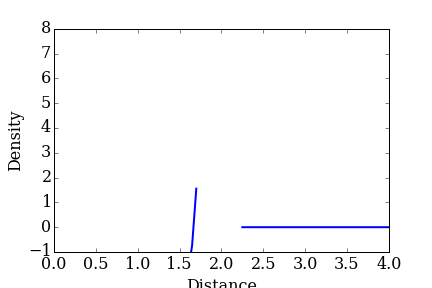
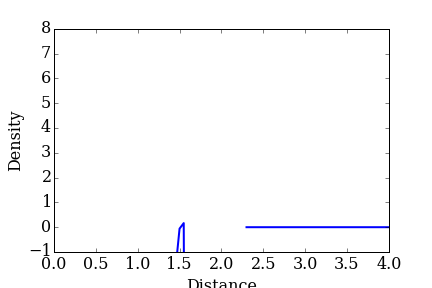
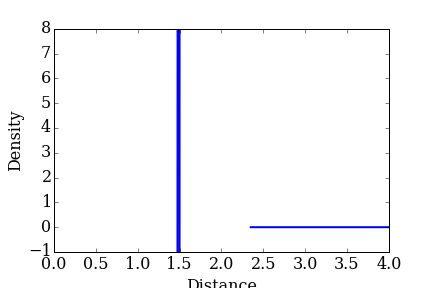
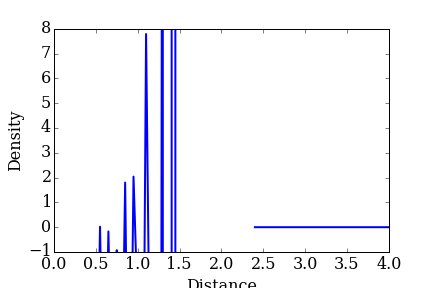
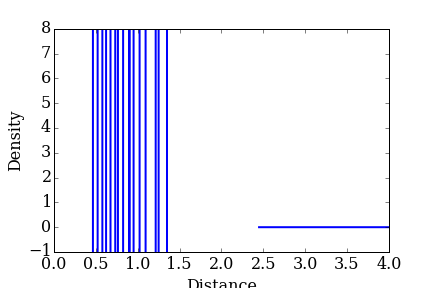
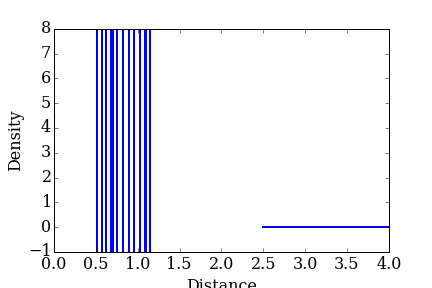
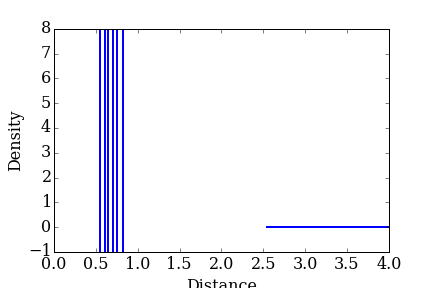
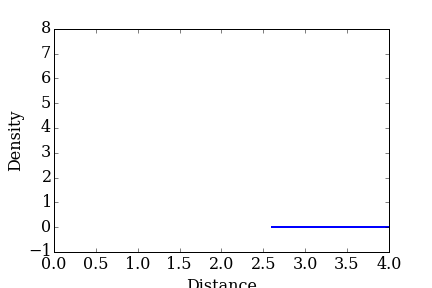
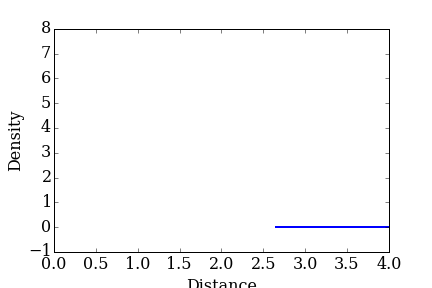
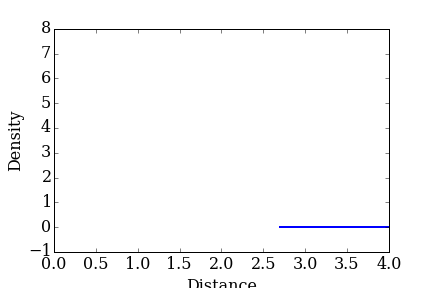
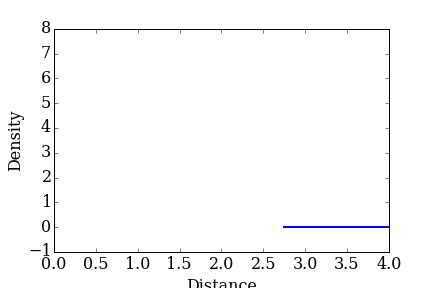
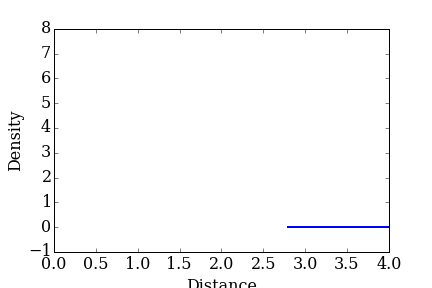
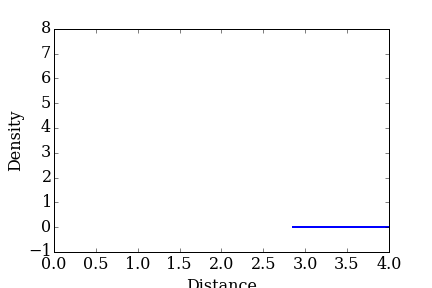
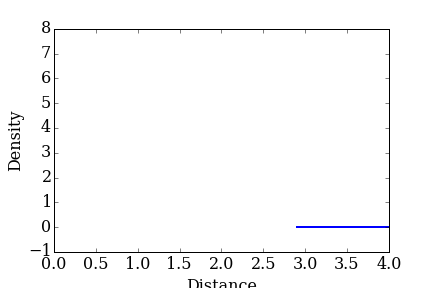
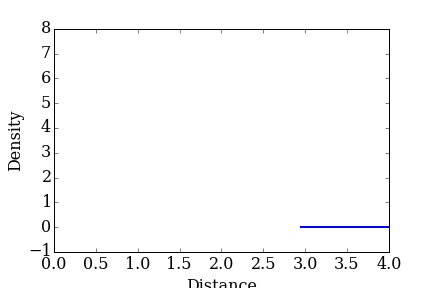
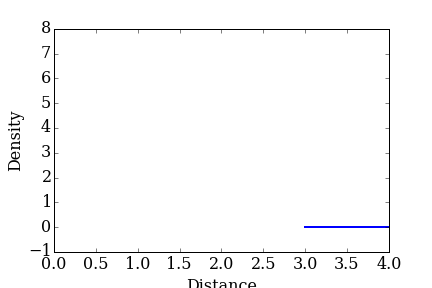
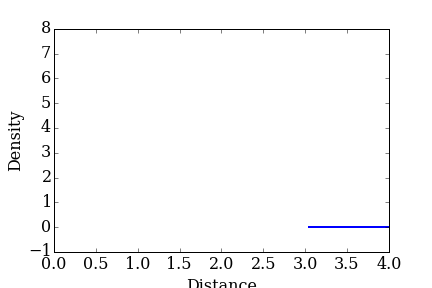
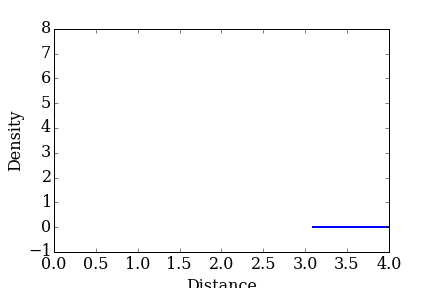
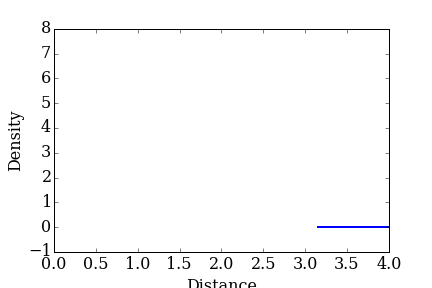
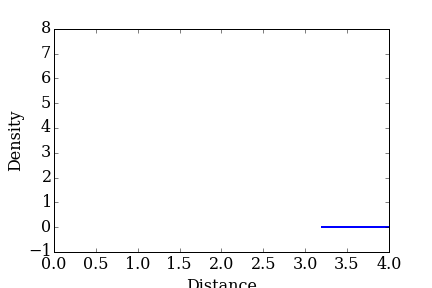
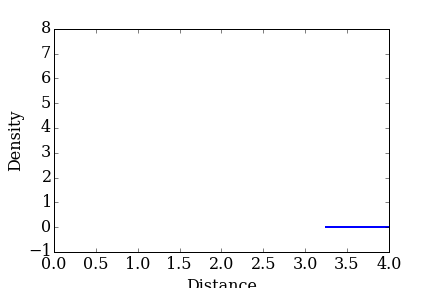
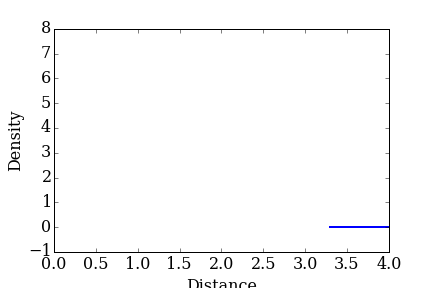
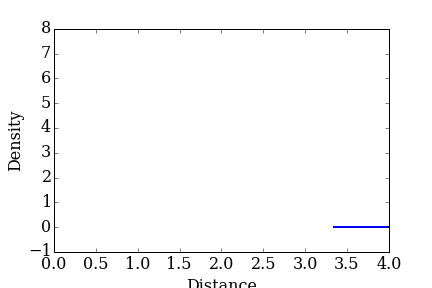
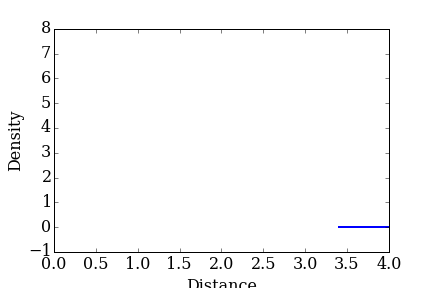
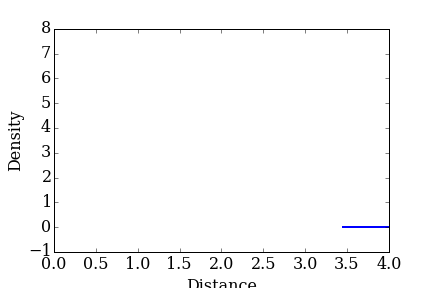

In [80]:
sigma = 1.
dt = sigma*dx/u_max

rho_n = maccormack(rho_initial, nt, dt, dx, rho_max, u_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(-1,8), xlabel=('Distance'), ylabel=('Density'))
line, = ax.plot([], [], lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')